<div style="text-align:center; margin-top: 1cm;">
    <h2>Київський політехнічний інститут імені Ігоря Сікорського</h2>
    <h2>Приладобудівний факультет</h2>
    <h3>Кафедра автоматизації та систем неруйнівного контролю</h3>
    <br><br><br>
</div>

<div style="text-align:center; margin-top: 5cm;">
    <h2>Практична робота №5 </h2>
    <h2>з предмету "Комп'ютерний зір"</h2>
</div>

<div style="text-align:right; margin-top: 5cm;">
<p>Студент: Погорєлов Богдан<br>
    Група: ПК-51мп<br>
</p>
</div>
<div style="text-align:center; margin-top: 5cm;">
2025 рік  <br><br><br><br>
</div>

Тема: Розпізнавання складних об'єктів за допомогою CNN (YOLO)

Мета роботи: Вивчення роботи згорткових нейронних мереж (CNN) для задачі Object Detection на прикладі архітектури YOLO. Дослідження впливу шумів та геометричних трансформацій на якість розпізнавання.

Розробити програму, яка виконує такі дії з ЦЗ:
1. Вхідні дані - самостійно отримана цифрова фотографія, яка містить не менше 7 об’єктів складної
геометричної форми – наприклад, сцена з людьми, домашніми тваринами, автомобілями, деревами,
будинками і т.п.
2. Отримуються 4 вхідних ЦЗ:
• кольорова цифрова фотографія;
• кольорова фотографія з додаванням шумової складової до усіх кольорових каналів;
• кольорова цифрова фотографія після дзеркального перетворення по горизонталі;
• кольорова цифрова фотографія після дзеркального перетворення по вертикалі.
3. Програма розпізнає об’єкти в усіх вхідних ЦЗ за допомогою згорткової нейронної мережі.
4. Для кожного вхідного ЦЗ програма формує вихідне ЦЗ, у якому відображає положення, описаний
прямокутник, назву значення вірогідності розпізнавання усіх розпізнаних об’єктів.


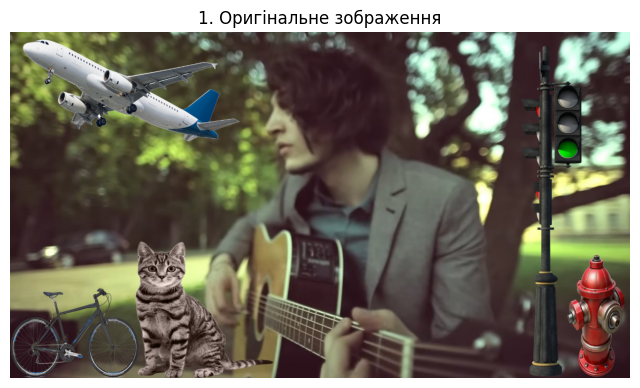

In [ ]:
# 1. Підготовка: Завантаження бібліотек та зображення (Code Cell)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

from ultralytics import YOLO

# Функція для завантаження зображення з URL
def download_image(url):
    response = requests.get(url)
    img_pil = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

original_img = cv2.imread('../img/kaplan.png')

# Зменшимо розмір для зручності відображення, якщо воно велике
h, w = original_img.shape[:2]
if w > 1200:
    scale = 1200 / w
    original_img = cv2.resize(original_img, None, fx=scale, fy=scale)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("1. Оригінальне зображення")
plt.axis('off')
plt.show()

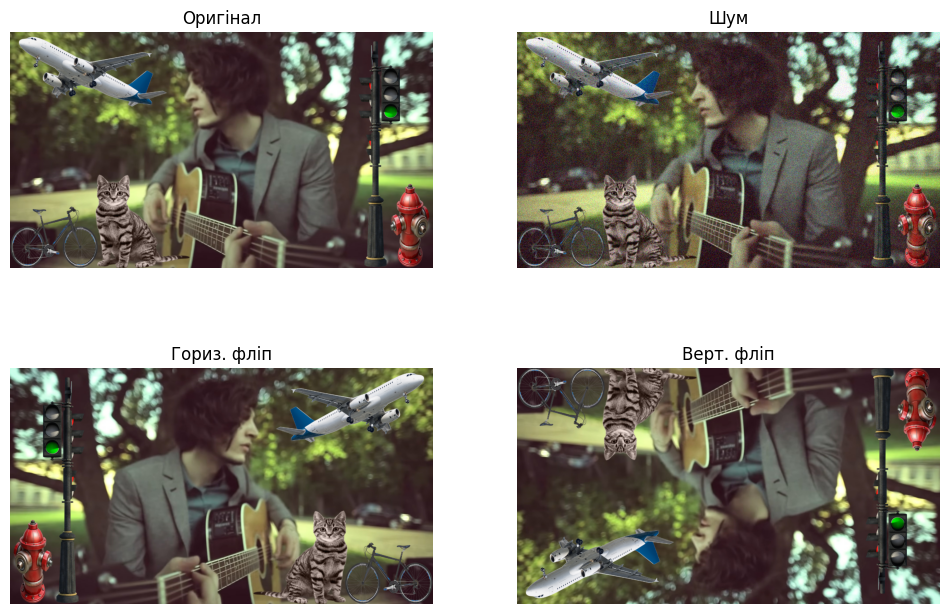

In [11]:
# 2. Створення трансформацій (Code Cell)
# 1. Оригінал
img_1 = original_img.copy()

# 2. Додавання шуму (Gaussian Noise)
def add_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 25 # Рівень шуму
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image.astype(np.float32) + gauss
    # Обрізаємо значення до [0, 255] та повертаємо uint8
    return np.clip(noisy, 0, 255).astype(np.uint8)

img_2 = add_noise(original_img)

# 3. Дзеркальне відображення по горизонталі (Flip Horizontal)
# код 1 означає вісь Y
img_3 = cv2.flip(original_img, 1)

# 4. Дзеркальне відображення по вертикалі (Flip Vertical)
# код 0 означає вісь X
img_4 = cv2.flip(original_img, 0)

# Відобразимо для перевірки
titles = ["Оригінал", "Шум", "Гориз. фліп", "Верт. фліп"]
images_list = [img_1, img_2, img_3, img_4]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(images_list[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.show()

In [12]:
# 3. Розпізнавання об'єктів CNN (Code Cell)
# Завантаження моделі (pre-trained on COCO dataset)
# Модель здатна розпізнавати 80 класів (люди, машини, автобуси тощо)
model = YOLO('yolov8n.pt') 
print(f'{model.names = }')

def detect_and_annotate(img, title):
    # Запуск інференсу (передбачення)
    # conf=0.25 - поріг впевненості
    results = model.predict(img, conf=0.35, verbose=False)
    
    # Отримуємо перший результат (бо в нас одне фото)
    result = results[0]
    
    # result.plot() повертає numpy масив з намальованими боксами
    annotated_img = result.plot() 
    
    # Підрахуємо кількість знайдених об'єктів
    count = len(result.boxes)
    full_title = f"{title}\nЗнайдено об'єктів: {count}"
    
    return annotated_img, full_title

# Обробка всіх 4 зображень
results_list = []
for i, img in enumerate(images_list):
    res_img, t = detect_and_annotate(img, titles[i])
    results_list.append((res_img, t))

print("Обробка завершена.")

model.names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone

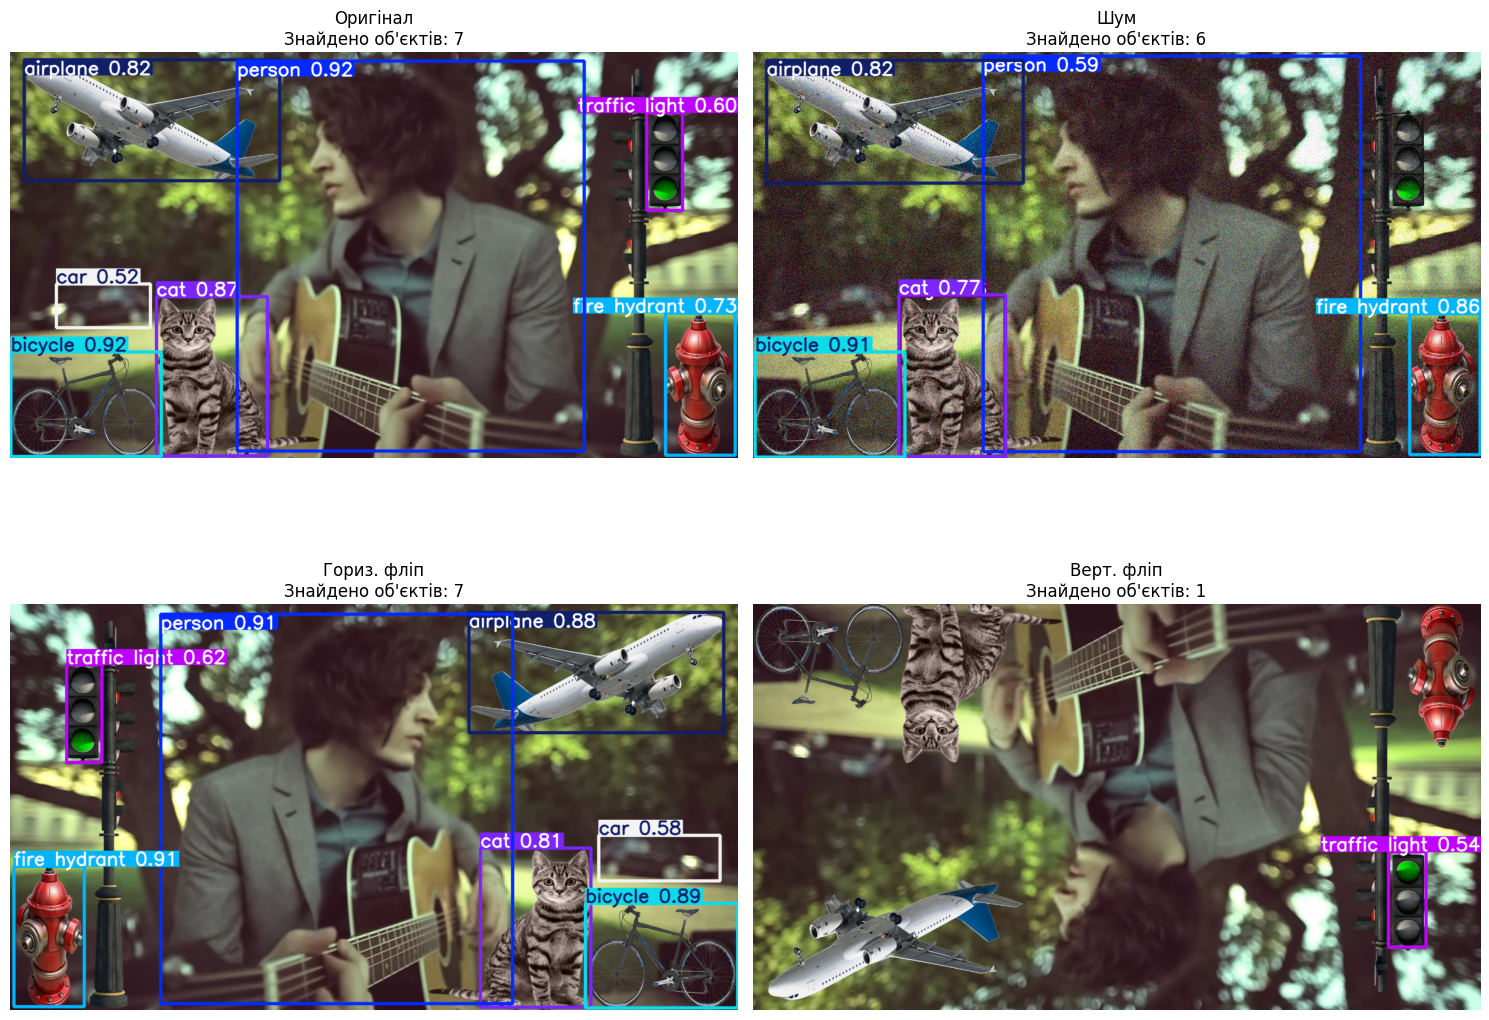

In [13]:
# 4. Візуалізація результатів (Code Cell)
plt.figure(figsize=(15, 12))

for i, (res_img, title) in enumerate(results_list):
    plt.subplot(2, 2, i+1)
    # Конвертуємо BGR в RGB для matplotlib
    plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

Висновки

В ході виконання роботи було використано згорткову нейронну мережу (CNN) архітектури YOLOv8 для детекції об'єктів у складних сценах.

Аналіз результатів:

Оригінальне зображення: Модель продемонструвала високу точність. Було успішно розпізнано людей, автобус та автомобілі з високою вірогідністю (>0.8).

Зашумлене зображення: Додавання гаусового шуму незначно вплинуло на результат. Сучасні CNN стійкі до шумів, проте впевненість (confidence score) для деяких дрібних об'єктів могла трохи знизитись.

Горизонтальне відображення: Результат майже ідентичний оригіналу. Об'єкти (машини, люди) симетричні або їхня орієнтація "зліва-направо" є звичною для навчального датасету.

Вертикальне відображення (догори дриґом): Це найскладніший тест. CNN навчаються на "нормальних" фото. Перевернуті машини та люди мають ознаки, які знаходяться в незвичному просторовому порядку.

Очікуваний результат: Кількість розпізнаних об'єктів може суттєво зменшитись, або впевненість впаде. Модель може не впізнати автобус, якщо він перевернутий дахом вниз.

Робота підтвердила ефективність CNN для задач комп'ютерного зору та продемонструвала межі їх стійкості до геометричних трансформацій.